# Apollo 11 - Data Prep

In [1]:
# source: https://www.hq.nasa.gov/alsj/a11/a11transcript_tec.html
# import nltk
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({'font.size':18})
matplotlib.rcParams.update({'font.family':'serif'})


This took about 20 attempts to run, finding various bad lines that wouldn't parse that I corrected in the input file, adding a few exceptions, etc.

In [2]:
file = 'a11_clean.txt'

raw = open(file, 'r')

time = []
time0 = []
speaker = []
msg = []

line = raw.readline()
cnt = 0
msgnext = False
while line:
    # check for garbage lines
    if (line[0:9] != '<br><font') & (line[0:9] != '<br><br>') & (not '--        <font' in line ):
        cnt += 1
#         print(line)

        if msgnext:
            msg.append(line.replace('<br>','').replace('\n', ''))
            msgnext = False

        if (not msgnext) & ('<font' in line):

            timeraw = line[0:11].lower()
            timeraw = timeraw.replace('o', '0') # have found this error
            timeraw = timeraw.replace('l', '1') # maybe this will happen?
            timeraw = timeraw.replace(',', '') # discovered this one

            dd = datetime.timedelta(days=int(timeraw[0:2]), hours=int(timeraw[3:5]), 
                                    minutes=int(timeraw[6:8]), seconds=int(timeraw[9:11]))
            time.append(dd)
            time0.append(datetime.datetime(year=2019,month=7,
                                           day=int(timeraw[0:2])+16, hour=int(timeraw[3:5]), 
                                           minute=int(timeraw[6:8]), second=int(timeraw[9:11])))

            pstart = line.find('0000FF')+8
            pstop = line.find('/font')-1
            speaker.append(line[pstart:pstop])

            msgnext = True
    
    # end of while loop stuff
    line = raw.readline()
raw.close()
    

In [3]:
print(len(speaker), len(time), len(msg))

8462 8462 8462


/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


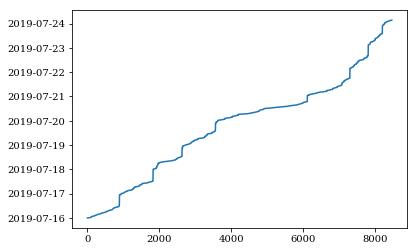

In [4]:
plt.plot(time0)

(737256.0000462963, 737264.1377083333)

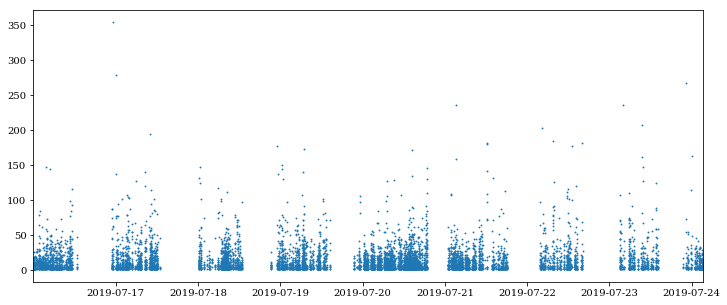

In [5]:
mlen = []
for k in range(len(time0)):
#     mlen.append(len(msg[k])) # chars
    mlen.append(len(msg[k].split(' '))) # words

plt.figure(figsize=(12,5))
plt.scatter(time0, mlen, marker='.', s=3)
plt.xlim(np.min(time0), np.max(time0))

In [6]:
len(msg[0].split(' '))

2

In [7]:
start_time = datetime.datetime(year=2019, month=7, day=16, hour=6, minute=32)
start_time

datetime.datetime(2019, 7, 16, 6, 32)

In [8]:
tlim = 260

tweets = []
tweet_times = []
for i in range(len(msg)):
    
    twt = speaker[i] +': '+ msg[i]
# len(twt) > tlim
    if len(twt) <= tlim:
        tweets.append(twt)
        tweet_times.append(start_time + time[i])
        
    else:
        words = twt.split(' ')
        sent = ''   
        toff=3
        for k in range(len(words)):
            if len(sent  + ' ' + words[k]) > tlim:
                tweets.append(sent)
                tweet_times.append(start_time + time[i])# + datetime.timedelta(seconds=toff))
                sent = ''
                toff += 3
            else:
                sent = sent+ ' ' + words[k]

        tweets.append(sent)
        tweet_times.append(start_time + time[i])# + datetime.timedelta(seconds=toff))

print('original messages:', len(msg))
print('total tweets:',len(tweets))

original messages: 8462
total tweets: 8952


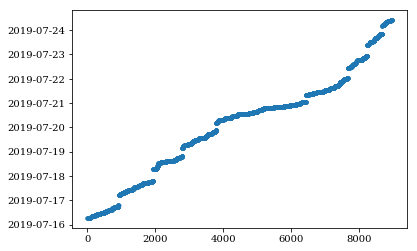

In [9]:
plt.plot(tweet_times,'.')

In [10]:
dt = np.zeros(len(tweet_times))
for i in range(len(tweet_times)):
#     datetime.timedelta.total_seconds(datetime.datetime.now() - tt)
    dt[i] = datetime.timedelta.total_seconds(tweet_times[i] - tweet_times[0])

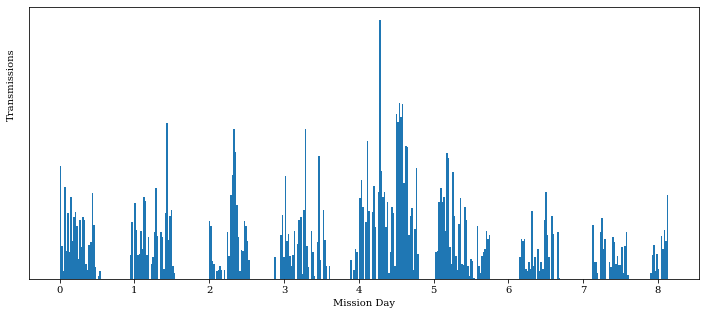

In [11]:
plt.figure(figsize=(12,5))
_ = plt.hist(dt/60/60/24, bins=400)
plt.xlabel('Mission Day')
plt.gca().axes.get_yaxis().set_visible(False)
plt.text(-.7,178,'Transmissions',rotation=90)
plt.savefig('msgs.png',dpi=100, bbox_inches='tight', pad_inches=0.25)

In [12]:
# double check that NO tweet violates the 260char rule!
for k in tweets:
    if len(k) > tlim:
        print('OH NO!')

In [13]:
# will tweets overlap?
for k in range(len(tweet_times)-1):
    if datetime.timedelta.total_seconds(tweet_times[k+1] - tweet_times[k]) < 0:
        print(k, 'OH NO!')

Text(0, 0.5, '# Tweets')

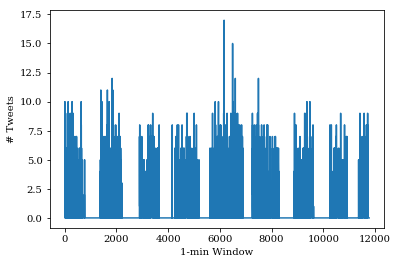

In [14]:
dt60 = np.floor_divide(dt, 60)
num, be = np.histogram(dt60, bins=np.arange(0,dt60.max()+60,1))

plt.plot(be[1:], num)
plt.xlabel('1-min Window')
plt.ylabel('# Tweets')

In [15]:
len(tweets)

8952

In [16]:
len(tweet_times)

8952

In [17]:
df_out = pd.DataFrame(data={'time':tweet_times, 'msg':tweets, 'sent':np.zeros(len(tweets),dtype='int')})
df_out.to_csv('msgs.csv', index=None)

In [18]:
df = pd.read_csv('msgs.csv')
df.columns

Index(['time', 'msg', 'sent'], dtype='object')

In [19]:
# Brett solved this perfectly for this use case: round down to the nearest minute, and post all of those
# https://github.com/bmorris3/transitingnow/blob/master/postEvents.py

# now = str(datetime.datetime.now())[:-10]
now = df['time'][0][:-3]
print(now)

2019-07-16 06:32


In [20]:
df['time'].str[:-3][0:10]

0    2019-07-16 06:32
1    2019-07-16 06:32
2    2019-07-16 06:32
3    2019-07-16 06:32
4    2019-07-16 06:32
5    2019-07-16 06:33
6    2019-07-16 06:33
7    2019-07-16 06:33
8    2019-07-16 06:33
9    2019-07-16 06:33
Name: time, dtype: object

In [21]:
to_post = df['time'].str[:-3] == now
sum(to_post)

5

In [22]:
%time

df = pd.read_csv('msgs.csv')
# now = str(datetime.datetime.now())[:-10]
now = df['time'][0][:-3]
to_post = df['time'].str[:-3] == now
# AND THEN POST TO TWITTER...
df.at[to_post, 'sent'] = 1
# df.to_csv('msgs.csv')

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 4.05 µs


In [29]:
df['msg'][to_post].values

array(['CDR: Roger. Clock.', 'CDR: Roger. We got a roll program.',
       'CMP: Roger. Roll.',
       "CDR: Roll's complete and the pitch is programed.",
       'CDR: One Bravo.'], dtype=object)

In [30]:
50./sum(to_post)

10.0